In [1]:
import pandas as pd
import numpy as np
import urllib.request

In [2]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv', 'course_lead_scoring.csv')

('course_lead_scoring.csv', <http.client.HTTPMessage at 0x24cba6e1510>)

In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [16]:
categorical_cols = ['lead_source', 'industry', 'employment_status', 'location']
numerical_cols = ['annual_income']

df[categorical_cols] = df[categorical_cols].fillna('na')
df[numerical_cols] = df[numerical_cols].fillna(0.0)

print(df.isnull().sum())



lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [15]:
df.head(10)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NA,africa,6,0.83,1
6,social_media,technology,0,51283.0,NA,middle_east,2,0.57,0
7,social_media,NA,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


In [6]:
from sklearn.model_selection import train_test_split

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
from sklearn.metrics import roc_auc_score

In [19]:
numerical_vars = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

for var in numerical_vars:
    scores = df_train[var]
    y_true = df_train['converted']
    auc = roc_auc_score(y_true, scores)
    if auc < 0.5:
        auc_neg = roc_auc_score(y_true, -scores)
        print(f'{var}: AUC={auc:.3f} -> inverted to {auc_neg:.3f}')
    else:
        print(f'{var}: AUC={auc:.3f}')


number_of_courses_viewed: AUC=0.764
annual_income: AUC=0.552
interaction_count: AUC=0.738
lead_score: AUC=0.614


In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [21]:
features = ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']
X_train_dict = df_train[features].to_dict(orient='records')
X_val_dict = df_val[features].to_dict(orient='records')

y_train = df_train['converted']
y_val = df_val['converted']

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(X_train_dict)
X_val = dv.transform(X_val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred_prob)
print(f'{auc:.3f}')

0.817


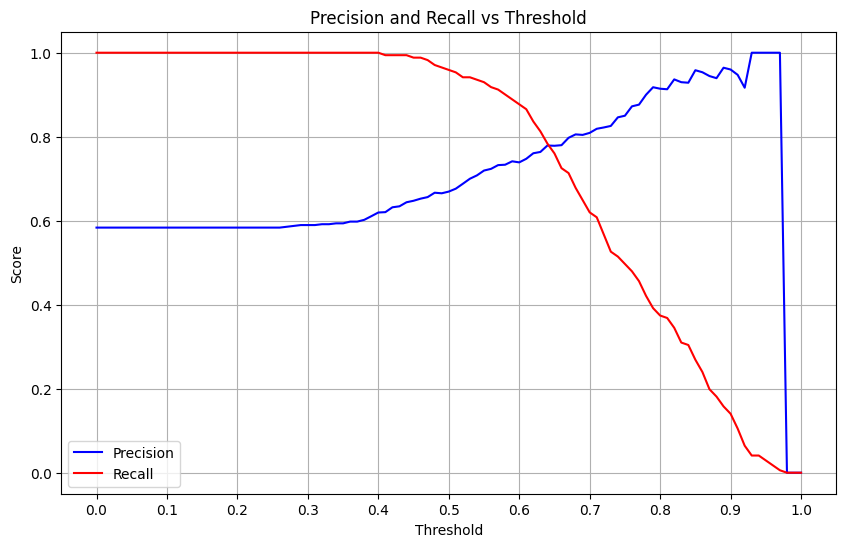

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score


thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.show()

In [23]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]
precision_at_max_f1 = precision_score(y_val, (y_pred_prob >= max_f1_threshold).astype(int), zero_division=0)
recall_at_max_f1 = recall_score(y_val, (y_pred_prob >= max_f1_threshold).astype(int))

print(f'F1 is maximal at threshold: {max_f1_threshold:.2f}')
print(f'Maximal F1 score: {max_f1_value:.3f}')
print(f'Precision at max F1: {precision_at_max_f1:.3f}')
print(f'Recall at max F1: {recall_at_max_f1:.3f}')

F1 is maximal at threshold: 0.57
Maximal F1 score: 0.812
Precision at max F1: 0.732
Recall at max F1: 0.912


In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df_train = df.iloc[train_index]
    df_val = df.iloc[val_index]
    
    X_train_dict = df_train[features].to_dict(orient='records')
    X_val_dict = df_val[features].to_dict(orient='records')
    
    y_train = df_train['converted']
    y_val = df_val['converted']
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(X_train_dict)
    X_val = dv.transform(X_val_dict)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_prob)
    aucs.append(auc)
    print(f'Fold {fold+1}: AUC = {auc:.3f}')

print(f'Mean AUC across 5 folds: {np.mean(aucs):.3f}')
print(f'Standard deviation of AUC: {np.std(aucs):.3f}')

Fold 1: AUC = 0.817
Fold 2: AUC = 0.779
Fold 3: AUC = 0.831
Fold 4: AUC = 0.868
Fold 5: AUC = 0.809
Mean AUC across 5 folds: 0.821
Standard deviation of AUC: 0.029


In [ ]:
c_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in c_values:
    aucs = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        df_train = df.iloc[train_index]
        df_val = df.iloc[val_index]
        
        X_train_dict = df_train[features].to_dict(orient='records')
        X_val_dict = df_val[features].to_dict(orient='records')
        
        y_train = df_train['converted']
        y_val = df_val['converted']
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train_dict)
        X_val = dv.transform(X_val_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_prob)
        aucs.append(auc)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    results[C] = {'mean': mean_auc, 'std': std_auc}
    print(f'C = {C}: Mean AUC = {mean_auc:.3f}, Std AUC = {std_auc:.3f}')

best_c = max(results, key=lambda x: results[x]['mean'])
print('Best C:', best_c, 'with mean AUC =', results[best_c]['mean'])

C = 1e-06: Mean AUC = 0.549, Std AUC = 0.030
C = 0.001: Mean AUC = 0.862, Std AUC = 0.024
C = 1: Mean AUC = 0.821, Std AUC = 0.029
Best C: 0.001 with mean AUC = 0.8624023620247024
